# 🤖 Natural Images Recogniser

A neural network will be developed that classifies several types of images. To do so, we are going to use a dataset contained in our Google Drive account obtained through [Kaggle](https://www.kaggle.com/datasets/briansurezsantiago/natural-images). This dataset is made up of 8 different classes listed below, where each of these classes contains 560 images that will be used during the training process. Similarly, these same classes are available to be used in the validation phase, each of these classes containing 140 different images.

*   Airplane
*   Car
*   Cat
*   Dog
*   Flower
*   Fruit
*   Motorbike
*   Person

In [1]:
# Mounts the Google Drive directory in which the dataset is hosted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Am I really using a GPU? Check in **Edit / Notebook Settings** or **Runtime / Change runtime type**.

In [2]:
# Check that we are making use of a GPU for training the neural network
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Let's see an example image.

Training  Validation


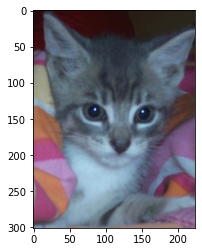

In [3]:
# List the directories available in the dataset to know the organisation of the data
!ls "/content/drive/My Drive/Colab Notebooks/datasets/NaturalDataset/"

# An example image is displayed, which will be used during the training phase of the network to determine the size of the image
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/NaturalDataset/Training/cat/cat_0250.jpg', 'r')
imshow(np.asarray(pil_im))

## 1️⃣ First Model

In [4]:
# Data source

image_size = (100, 100)  # Images of 100x100 dimension
batch_size = 32          # Number of images that are passed to the network per epoch

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/NaturalDataset/Training",
    validation_split=0.2,     # 20% of images for validation
    subset="training",
    seed=1337,                # In an iteration, we do not feed the network with all the images but with small portions given by the batch_size
    image_size=image_size,    # Size of our dataset images
    batch_size=batch_size, 
    label_mode='categorical'  # The network classifies more than two classes (categorical), if the network would classify two classes (binary)
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/NaturalDataset/Validation",
    validation_split=0.2,     # 80% of images for training
    subset="validation",
    seed=1337,                # This is a specific way of randomising the data used during the training phase of the network
    image_size=image_size,    # Recommended images sizes (100, 200, 512)
    batch_size=batch_size,
    label_mode='categorical' 
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4480 files belonging to 8 classes.
Using 3584 files for training.
Found 1120 files belonging to 8 classes.
Using 224 files for validation.


In [5]:
# Convolutional Neural Network Model

from tensorflow import keras        
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

model = keras.Sequential()            # Model initialisation mode. Sequential mode adds one layer after another
model.add(Rescaling(scale=(1./127.5), # Layer for the normalisation of the dataset image set
                    offset=-1,
                    input_shape=(100, 100, 3)))               # Size of the input images

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))  # First convolutional layer. Fully connected layer
model.add(MaxPooling2D(pool_size=(2, 2)))                     # Halves the image (in our case, the image would be 49x49)

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))  # kernel_size = image filter
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Deactivates 25% of the neurons, forcing the network to rely on the remaining neurons available for training

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Causes it to stop using the same neurons during the learning phase (switches them off in the previous layer)

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))

model.add(Flatten())                      # Converts the matrix into a vector
model.add(Dense(128, activation='relu'))  # Simplification of the vector obtained above
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax')) # The first parameter specifies the number of classes the dataset has

# Specify the model compilation mode
model.compile(loss=tf.keras.losses.categorical_crossentropy,  # Loss function
              optimizer=tf.keras.optimizers.Adam(1e-3),       # Adam optimiser (based on SGD = Stochastic Gradient Descent)
              metrics=['accuracy'])                           # Metric that measures the learning accuracy of the network in each epoch

In [6]:
# Training Phase

epochs = 200

# Once the highest value is reached in the network and it stabilises or starts
# to have losses, the training process is stopped. The parameter patience=10 makes
# it stop after 10 waiting epochs when the highest value has been recorded and the
# model has not improved, so that finally we will have the best value and therefore
# the best weights.
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

# The model fits the given training and validation data, the number of epochs and each of the previously implemented layers
h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
112/112 [==============================] - 11s 65ms/step - loss: 1.9325 - accuracy: 0.2065 - val_loss: 1.7984 - val_accuracy: 0.4330
Epoch 2/200
112/112 [==============================] - 10s 81ms/step - loss: 1.4857 - accuracy: 0.4428 - val_loss: 1.3820 - val_accuracy: 0.5045
Epoch 3/200
112/112 [==============================] - 9s 80ms/step - loss: 1.1363 - accuracy: 0.5896 - val_loss: 1.0133 - val_accuracy: 0.6339
Epoch 4/200
112/112 [==============================] - 9s 79ms/step - loss: 0.9718 - accuracy: 0.6526 - val_loss: 0.9870 - val_accuracy: 0.6518
Epoch 5/200
112/112 [==============================] - 9s 80ms/step - loss: 0.8339 - accuracy: 0.6953 - val_loss: 0.8054 - val_accuracy: 0.6696
Epoch 6/200
112/112 [==============================] - 9s 80ms/step - loss: 0.7076 - accuracy: 0.7344 - val_loss: 0.6261 - val_accuracy: 0.7634
Epoch 7/200
112/112 [==============================] - 10s 84ms/step - loss: 0.7012 - accuracy: 0.7517 - val_loss: 0.6872 - val_accura

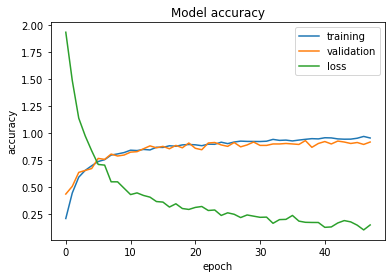

In [7]:
# Graphical representation of the results obtained during the training phase

import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## 📉 Evaluation of the results

              precision    recall  f1-score   support

           0     0.8333    0.9524    0.8889        21
           1     0.9189    1.0000    0.9577        34
           2     0.9259    0.7576    0.8333        33
           3     0.7812    0.8333    0.8065        30
           4     1.0000    1.0000    1.0000        31
           5     1.0000    1.0000    1.0000        25
           6     1.0000    0.9091    0.9524        22
           7     1.0000    1.0000    1.0000        28

    accuracy                         0.9286       224
   macro avg     0.9324    0.9315    0.9299       224
weighted avg     0.9319    0.9286    0.9280       224



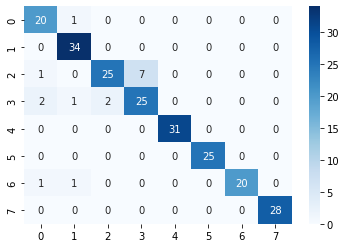

In [8]:
# Confusion matrix. Allow visualisation of neural network performance

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [9]:
# Validation Phase

img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/NaturalDataset/Validation/dog/dog_0002.jpg', target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)    # Once trained, the network tries to predict to which class the given validation image belongs
print(np.argmax(predictions[0])) 

# The result obtained below represents the classification performed by
# the neural network in this validation process after the training phase.
# From an image belonging to the set of validation images and not used in
# the training process, the network classifies and returns the number of
# the class to which this image belongs.

3
